# Deep Learning CA1 Part A Submission

**Student Name:** Irman Zafyree Bin Irmanizam

**Class:** DAAA/FT/2B/21

**Admin Number:** P2300546

# Background
## Objective
Build image classification models to recognise 15 types of vegetables. There are two input size given, 37 x 37 pixels and 131 x 131 pixels, thus 2 models must be made. The images must be converted to grayscale for both of the models. Once the models are builts and trained, compare and discuss the accuracies of both models.

## Task (Verbose)
Implement an image classifier using a deep learning network. You are given colour
images of 224 by 224 pixels, containing 15 types of vegetables.

You must convert the given images into grayscale (i.e. only 1 channel instead of 3).
Consider two different input sizes:

a) 37 by 37 pixels

b) 131 by 131 pixels

Do not use the original size of 224 by 224 pixels.

Build two types of neural networks, one for each input size. Compare and discuss the
classification accuracies for each input size

# Importing Libraries

In [18]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import functions as cnnf

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import clone_model

## Other Preparation

In [19]:
# Fixing random seed
seed = 999
np.random.seed(seed)
tf.random.set_seed(seed)

In [20]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(tf.config.experimental.get_device_details(gpu))
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPUs")

{'device_name': 'NVIDIA GeForce RTX 3090', 'compute_capability': (8, 6)}
There are 1 GPUs


# Data Preparation

In [21]:
dataset_path = "./Dataset_PartA/Dataset for CA1 part A - AY2425S1"

train_folder = os.path.join(dataset_path,"train")
test_folder = os.path.join(dataset_path,"test")
validation_folder = os.path.join(dataset_path,"validation")

# These are the paths of the train, test, and validation folders for the dataset

In [22]:
train_vege_count = pd.DataFrame(columns=["Name", "Count"])
test_vege_count = pd.DataFrame(columns=["Name", "Count"])
validation_vege_count = pd.DataFrame(columns=["Name", "Count"])

def pop_vege_count(data_folder, vege_count):
    for folder in os.listdir(data_folder):
        count = len(os.listdir(os.path.join(data_folder, folder)))
        vege_count.loc[folder] = [folder,count]

pop_vege_count(train_folder, train_vege_count)
pop_vege_count(test_folder, test_vege_count)
pop_vege_count(validation_folder, validation_vege_count)

print(f"Train Data\n{train_vege_count}\n\n")

print(f"Test Data\n{test_vege_count}\n\n")

print(f"Validation Data\n{validation_vege_count}\n\n")

Train Data
                      Name  Count
Bean                  Bean    795
Bitter_Gourd  Bitter_Gourd    720
Bottle_Gourd  Bottle_Gourd    441
Brinjal            Brinjal    868
Broccoli          Broccoli    750
Cabbage            Cabbage    503
Capsicum          Capsicum    351
Carrot              Carrot    256
Cauliflower    Cauliflower    587
Cucumber          Cucumber    812
Papaya              Papaya    566
Potato              Potato    377
Pumpkin            Pumpkin    814
Radish              Radish    248
Tomato              Tomato    955


Test Data
                      Name  Count
Bean                  Bean    200
Bitter_Gourd  Bitter_Gourd    200
Bottle_Gourd  Bottle_Gourd    200
Brinjal            Brinjal    200
Broccoli          Broccoli    200
Cabbage            Cabbage    200
Capsicum          Capsicum    200
Carrot              Carrot    200
Cauliflower    Cauliflower    200
Cucumber          Cucumber    200
Papaya              Papaya    200
Potato              Potat

### Image Preprocessing

#### Grayscaling images

In [23]:
# following guide https://www.tensorflow.org/tutorials/images/classification
# Global Variables
batch_size = None
img_height = 224
img_weight = 224

# making image dataset
# image are converted to grayscale
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_folder,
    batch_size = batch_size,
    image_size = (img_height, img_weight),
    color_mode = "grayscale",
    seed = seed)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_folder,
    batch_size = batch_size,
    image_size = (img_height, img_weight),
    color_mode = "grayscale",
    seed = seed)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_folder,
    batch_size = batch_size,
    image_size = (img_height, img_weight),
    color_mode = "grayscale",
    seed = seed)
print(train_dataset.class_names)

Found 9043 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


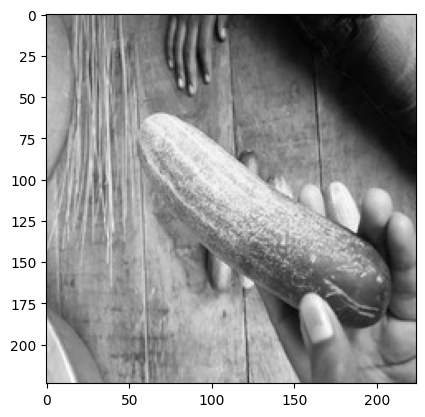

In [24]:
# Loading 1 images

for images,labels in train_dataset.take(1):
    img=images.numpy().astype("uint8")
    plt.imshow(img, cmap="gray")

#### Resizing the image & scaling the color scale

In [25]:
# followinh guide https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing
resizing_layer_131 = tf.keras.layers.Resizing(131,131)
resizing_layer_37 = tf.keras.layers.Resizing(37,37)
scaling_layer = tf.keras.layers.Rescaling(1./255)

train_dataset_131 = train_dataset.map(lambda x, y: (resizing_layer_131(x), y))
train_dataset_131_norm = train_dataset_131.map(lambda x, y: (scaling_layer(x), y))

test_dataset_131 = test_dataset.map(lambda x, y: (resizing_layer_131(x), y))
test_dataset_131_norm = test_dataset_131.map(lambda x, y: (scaling_layer(x), y))

validation_dataset_131 = validation_dataset.map(lambda x, y: (resizing_layer_131(x), y))
validation_dataset_131_norm = validation_dataset_131.map(lambda x, y: (scaling_layer(x), y))

train_dataset_37 = train_dataset.map(lambda x, y: (resizing_layer_37(x), y))
train_dataset_37_norm = train_dataset_37.map(lambda x, y: (scaling_layer(x), y))

test_dataset_37 = test_dataset.map(lambda x, y: (resizing_layer_37(x), y))
test_dataset_37_norm = test_dataset_37.map(lambda x, y: (scaling_layer(x), y))

validation_dataset_37 = validation_dataset.map(lambda x, y: (resizing_layer_37(x), y))
validation_dataset_37_norm = validation_dataset_37.map(lambda x, y: (scaling_layer(x), y))

# Background Research & Exploratory Data Analysis

Displaying the images for each class types in each of the respective resolution, 224, 131 & 37

In [26]:
class_names = train_dataset.class_names

### Images (224)

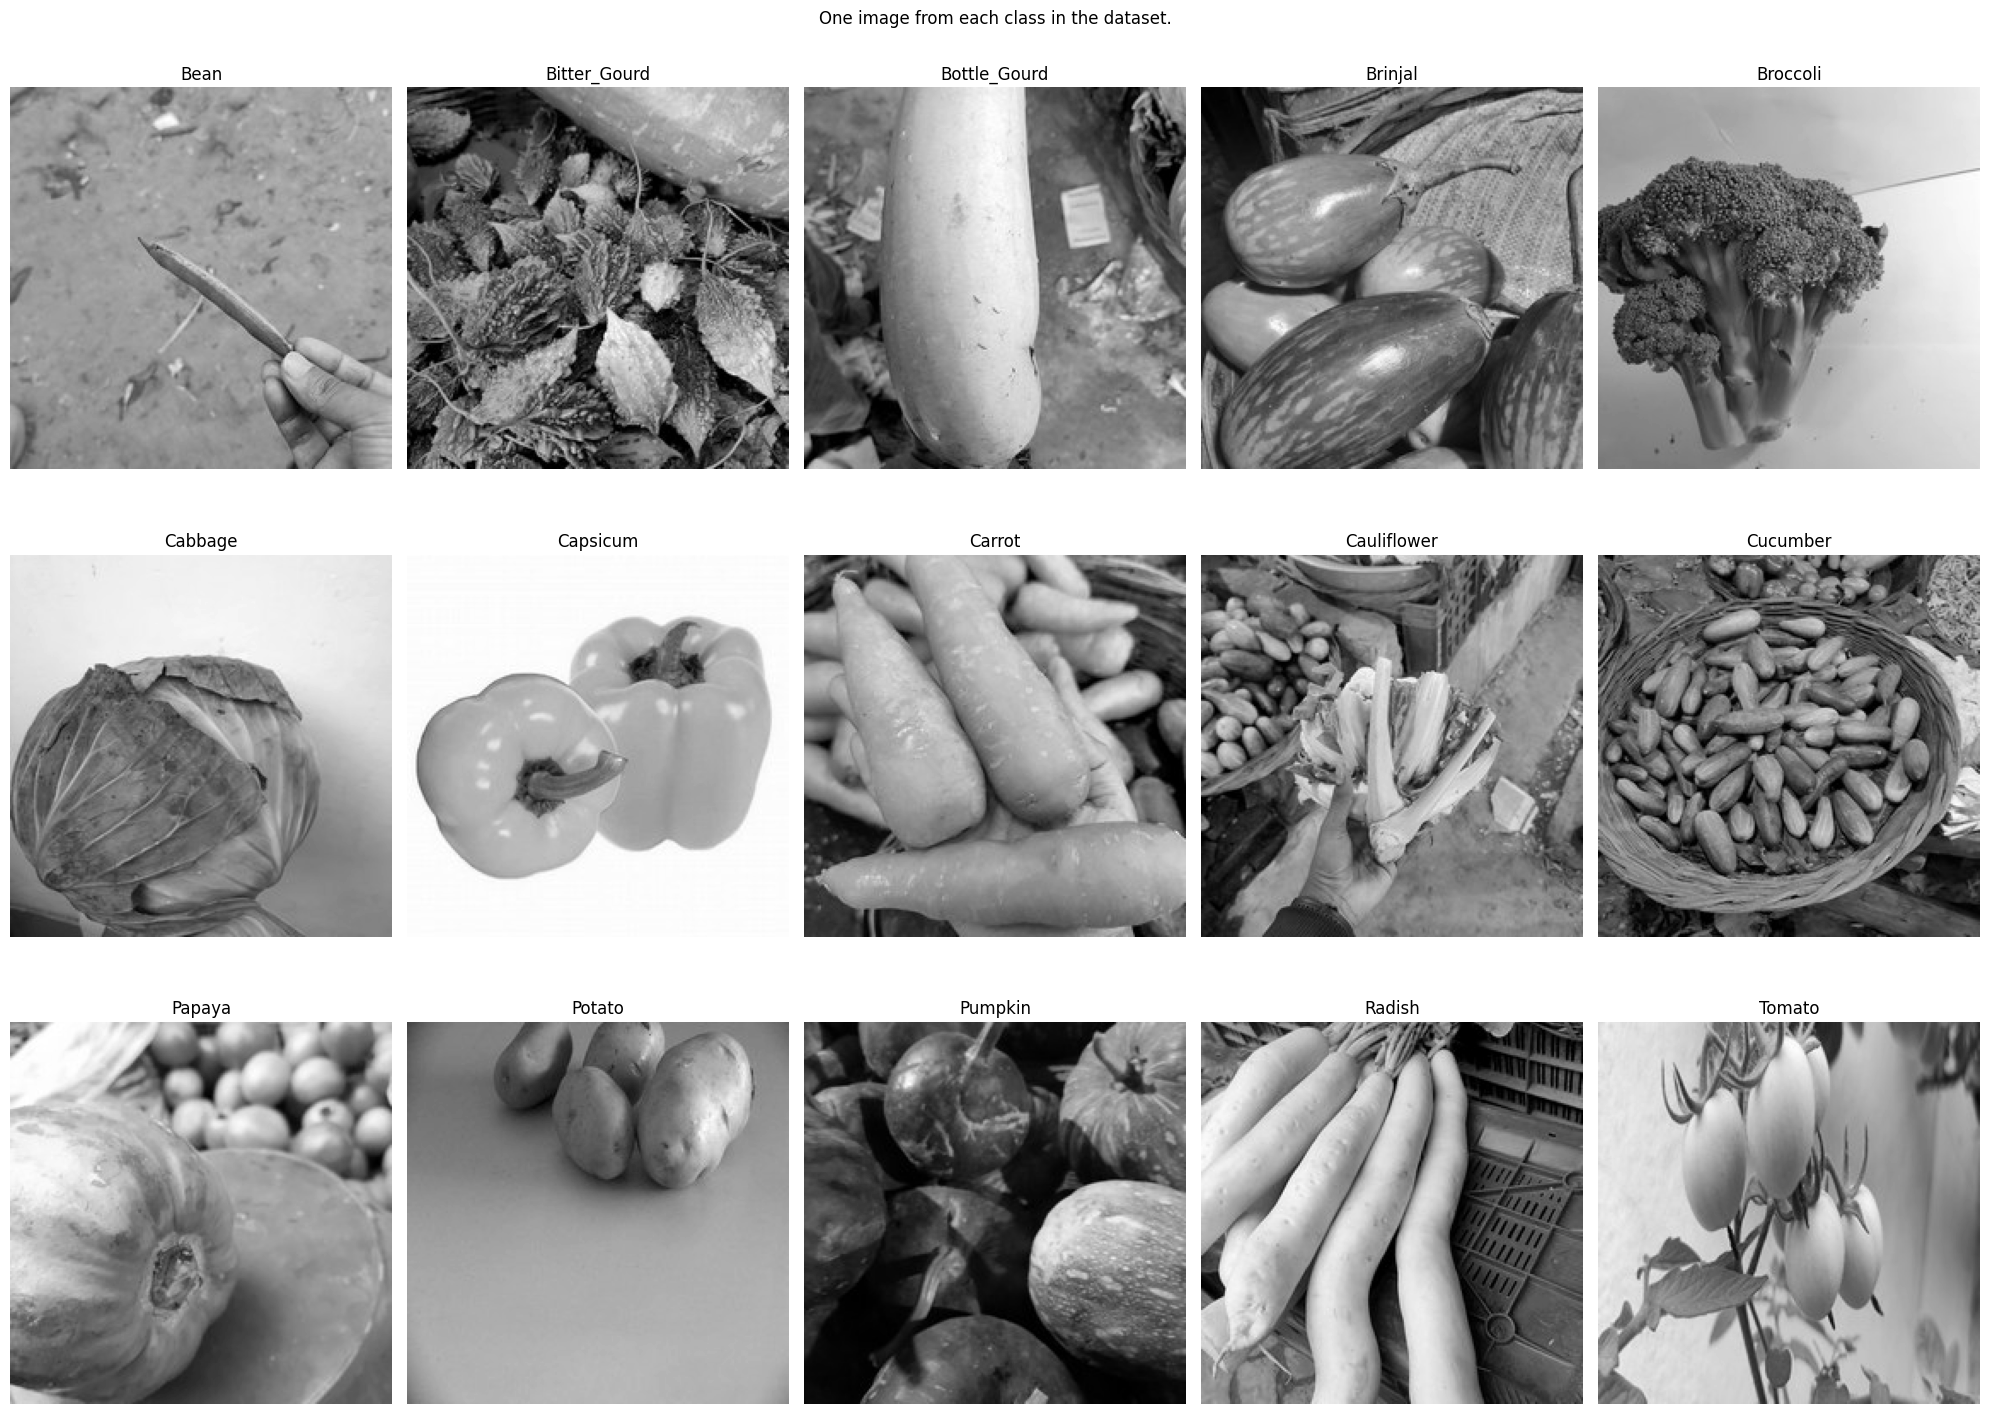

In [27]:
cnnf.class_image(train_dataset,class_names, cmap="gray")

### Images (131)

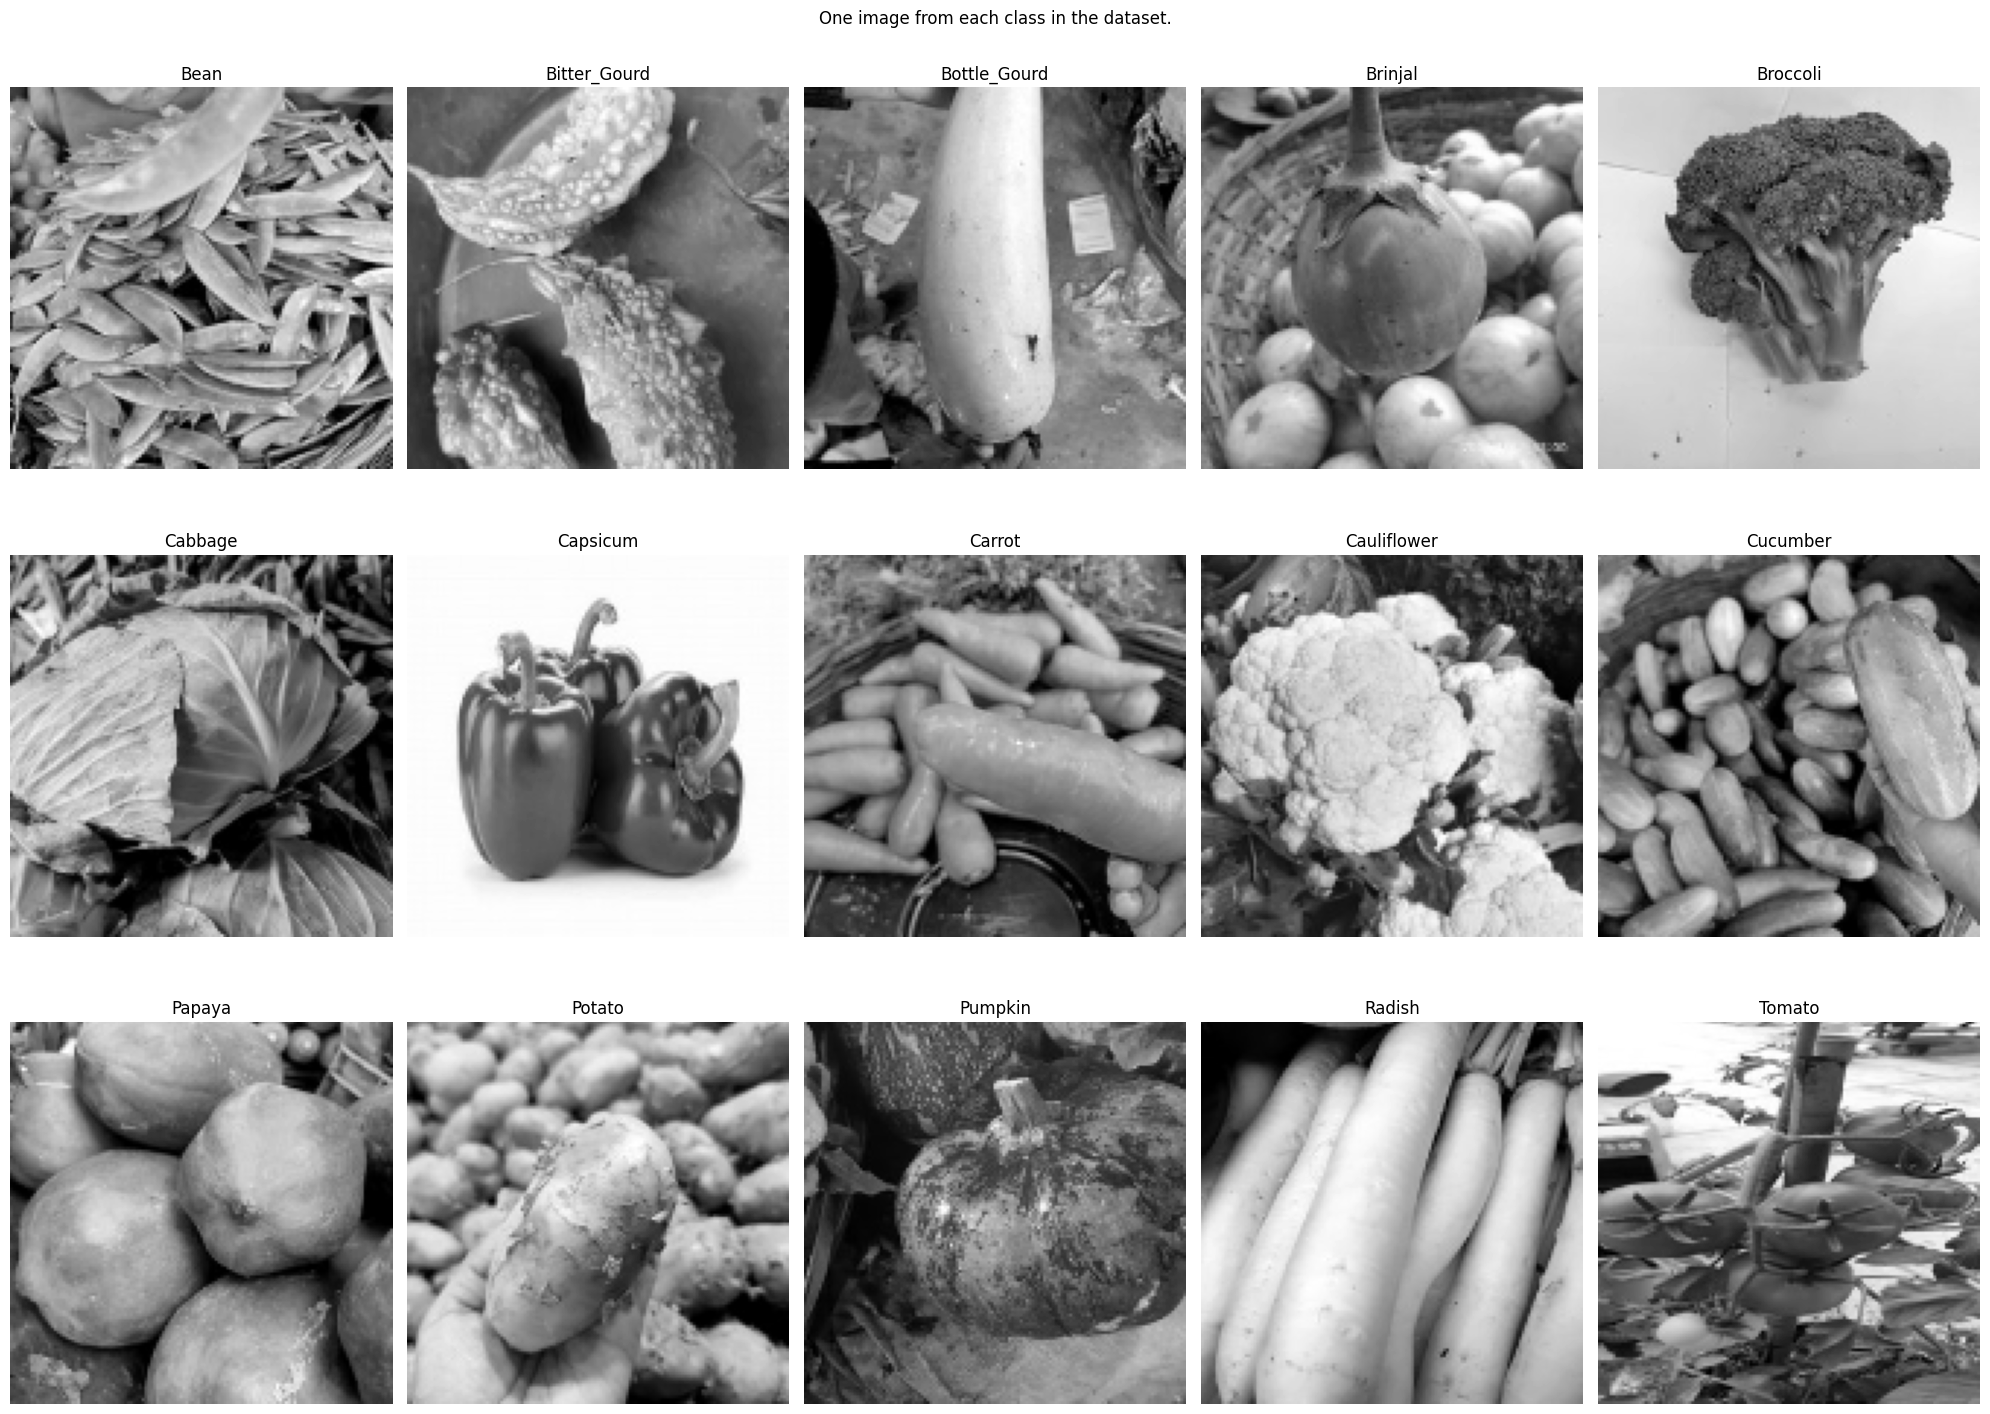

In [28]:
cnnf.class_image(train_dataset_131,class_names, cmap="gray")

### Images (37)

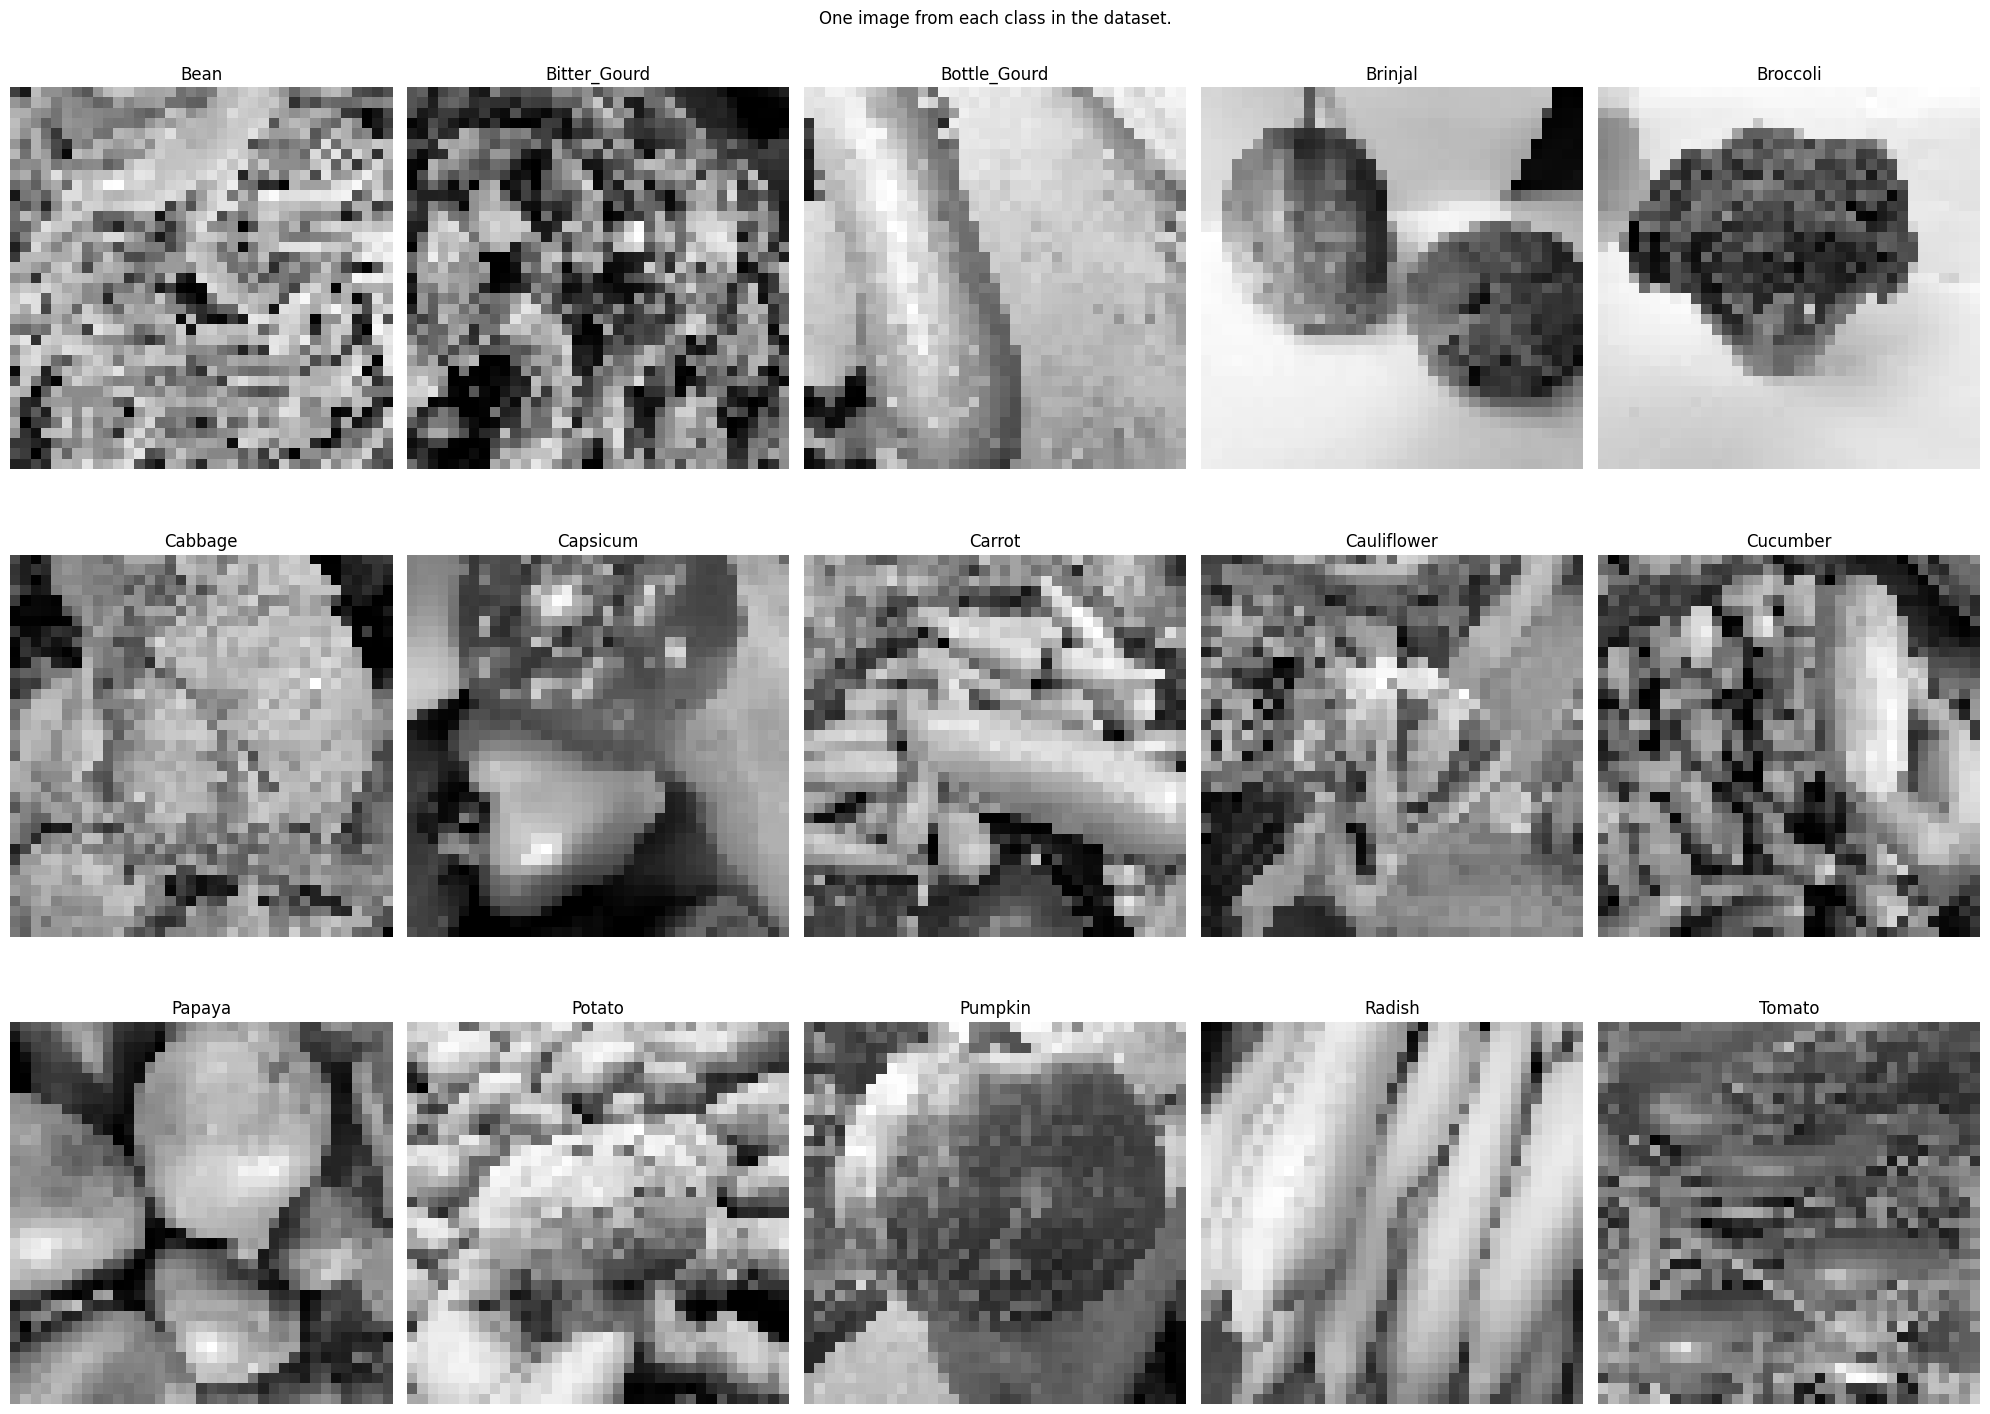

In [29]:
cnnf.class_image(train_dataset_37,class_names, cmap="gray")

From this, we can see that for the 131x131 resolution images, there is still visible edges and shapes that the model can use as features. 

However. for the 37x37 resolution images, it is difficult, for me, to even see the vegetable in some of the images. Especially for the images with other distraction in the background. This will it difficult for the model to identify unique features to each of the vegetables which can affect its accuracy.

### Average (131)

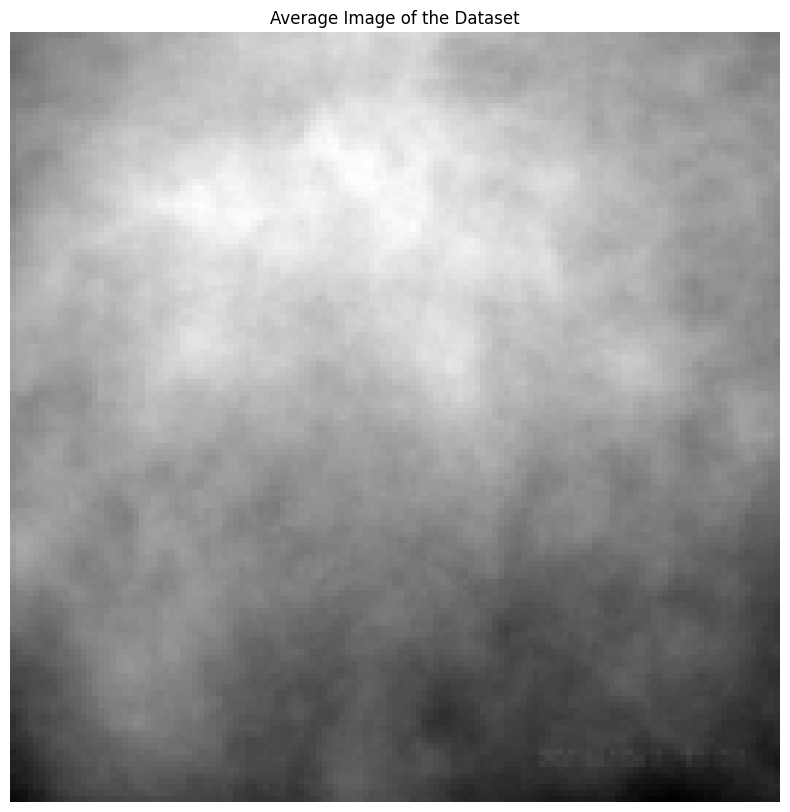

In [30]:
cnnf.average_image(train_dataset_131)

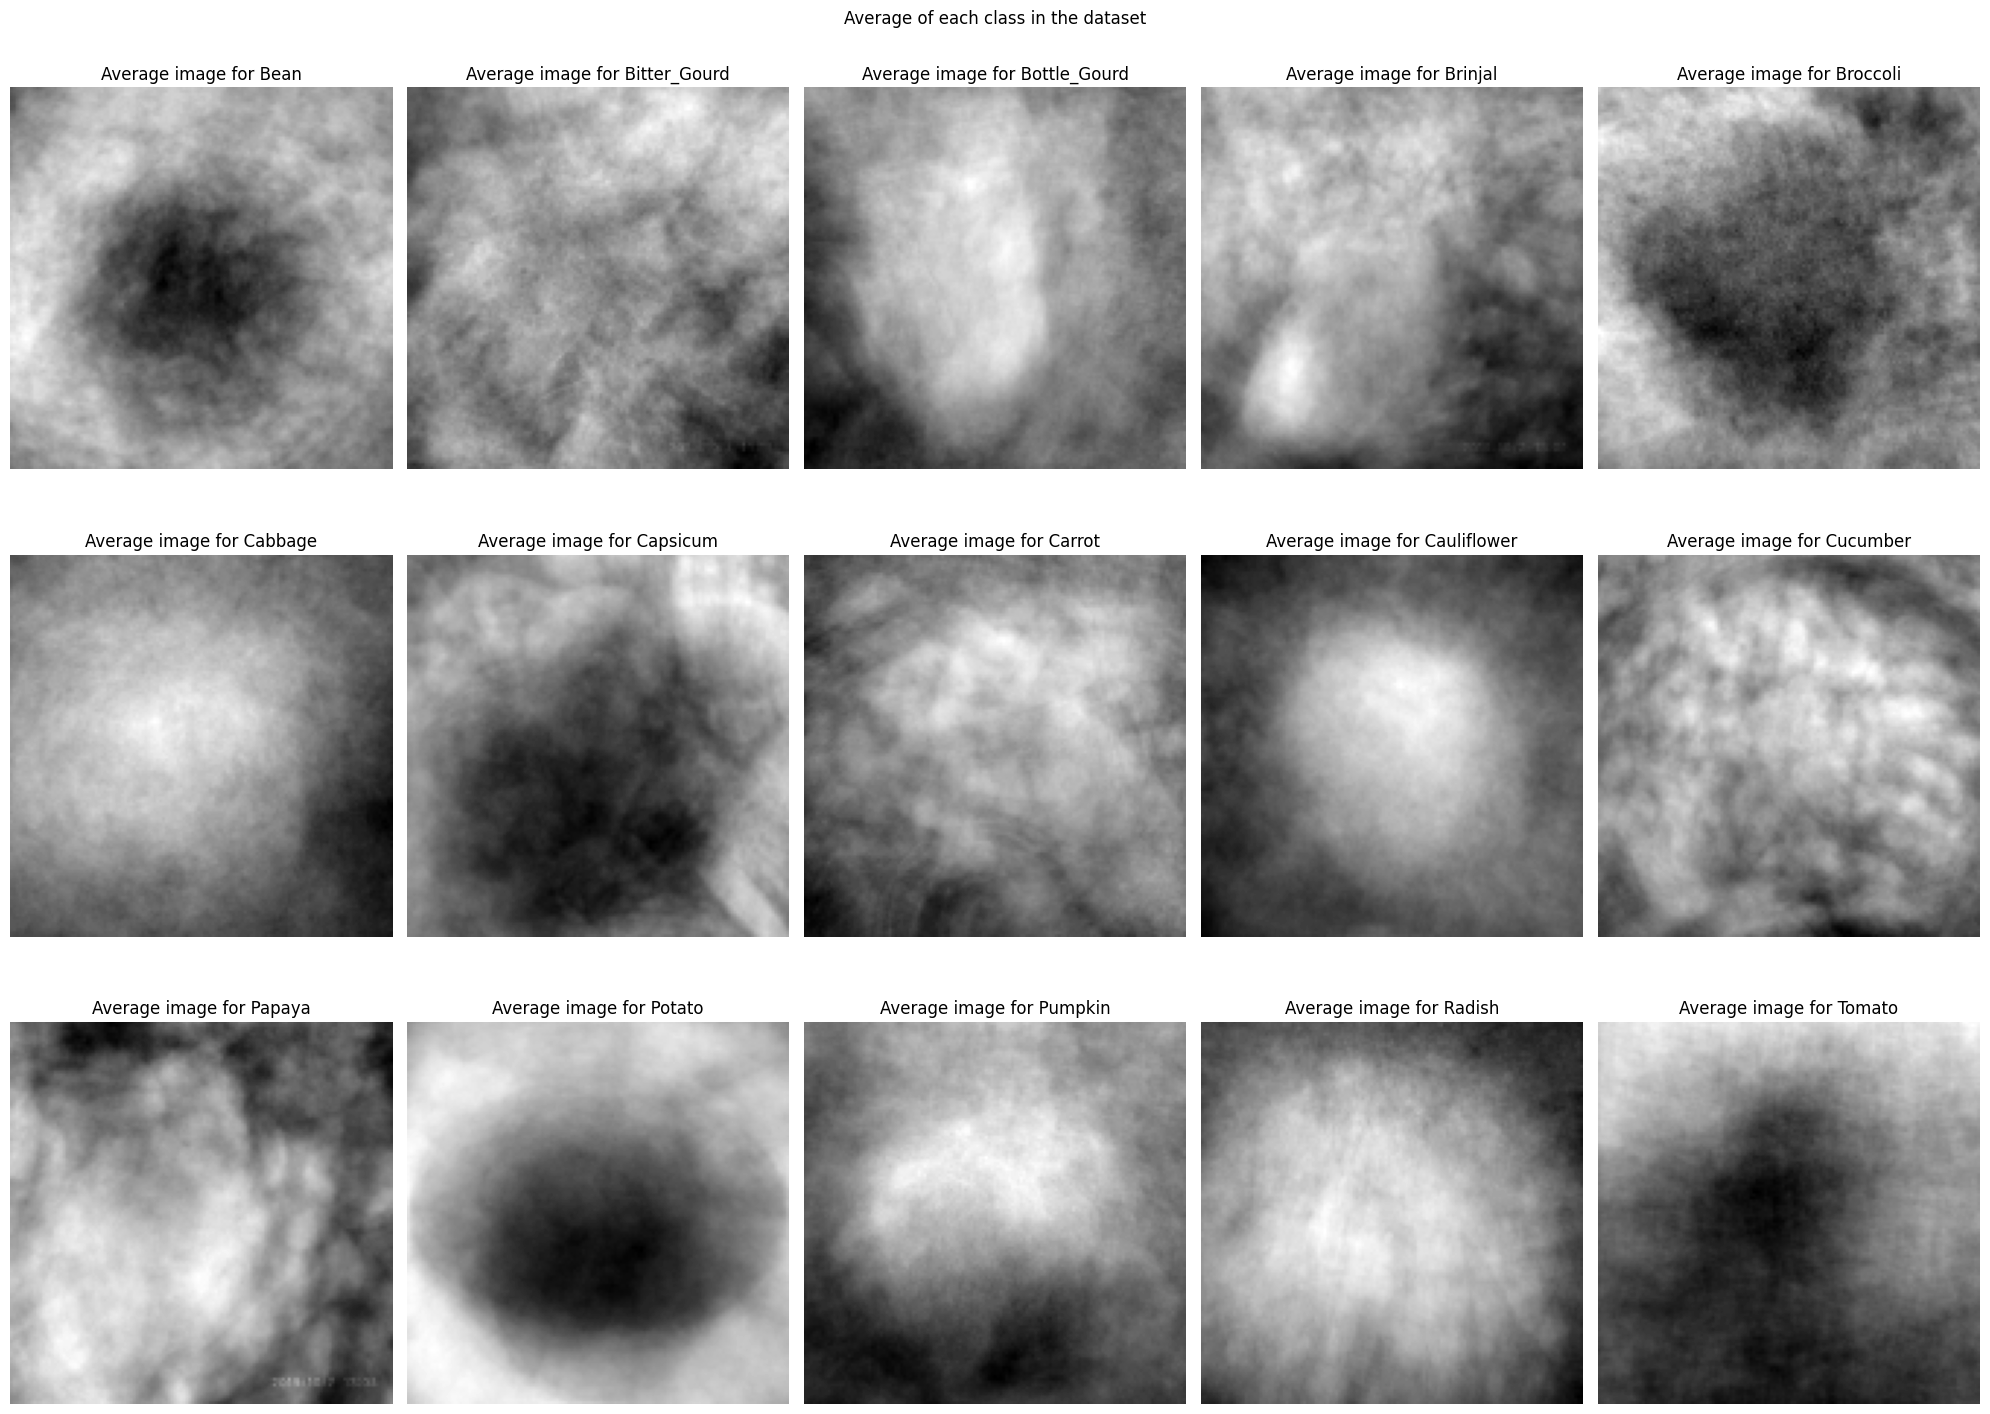

In [31]:
cnnf.average_images_per_class(train_dataset_131,class_names)

### Average (37)

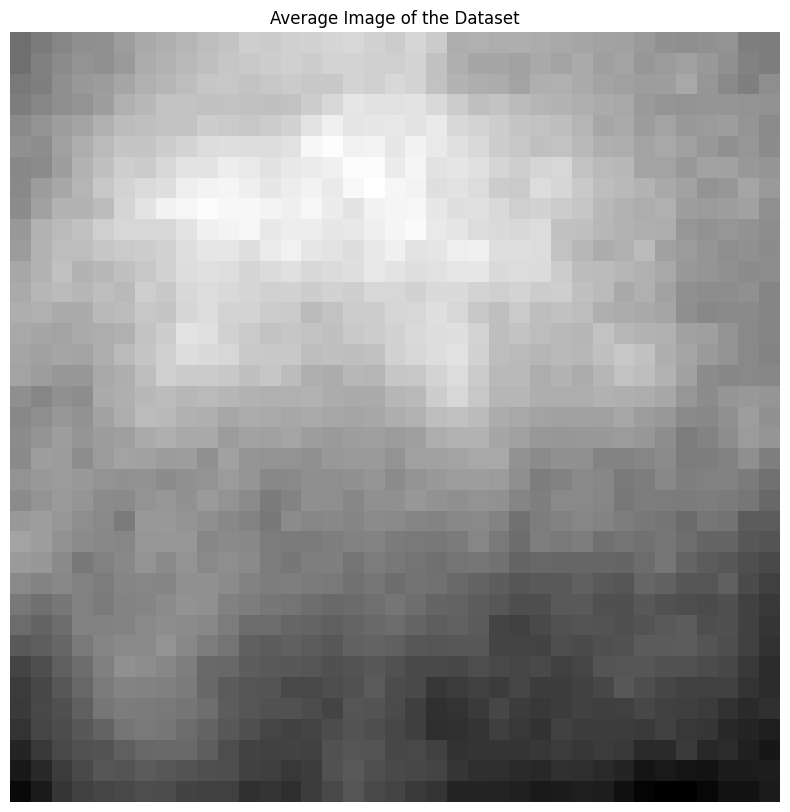

In [32]:
cnnf.average_image(train_dataset_37)

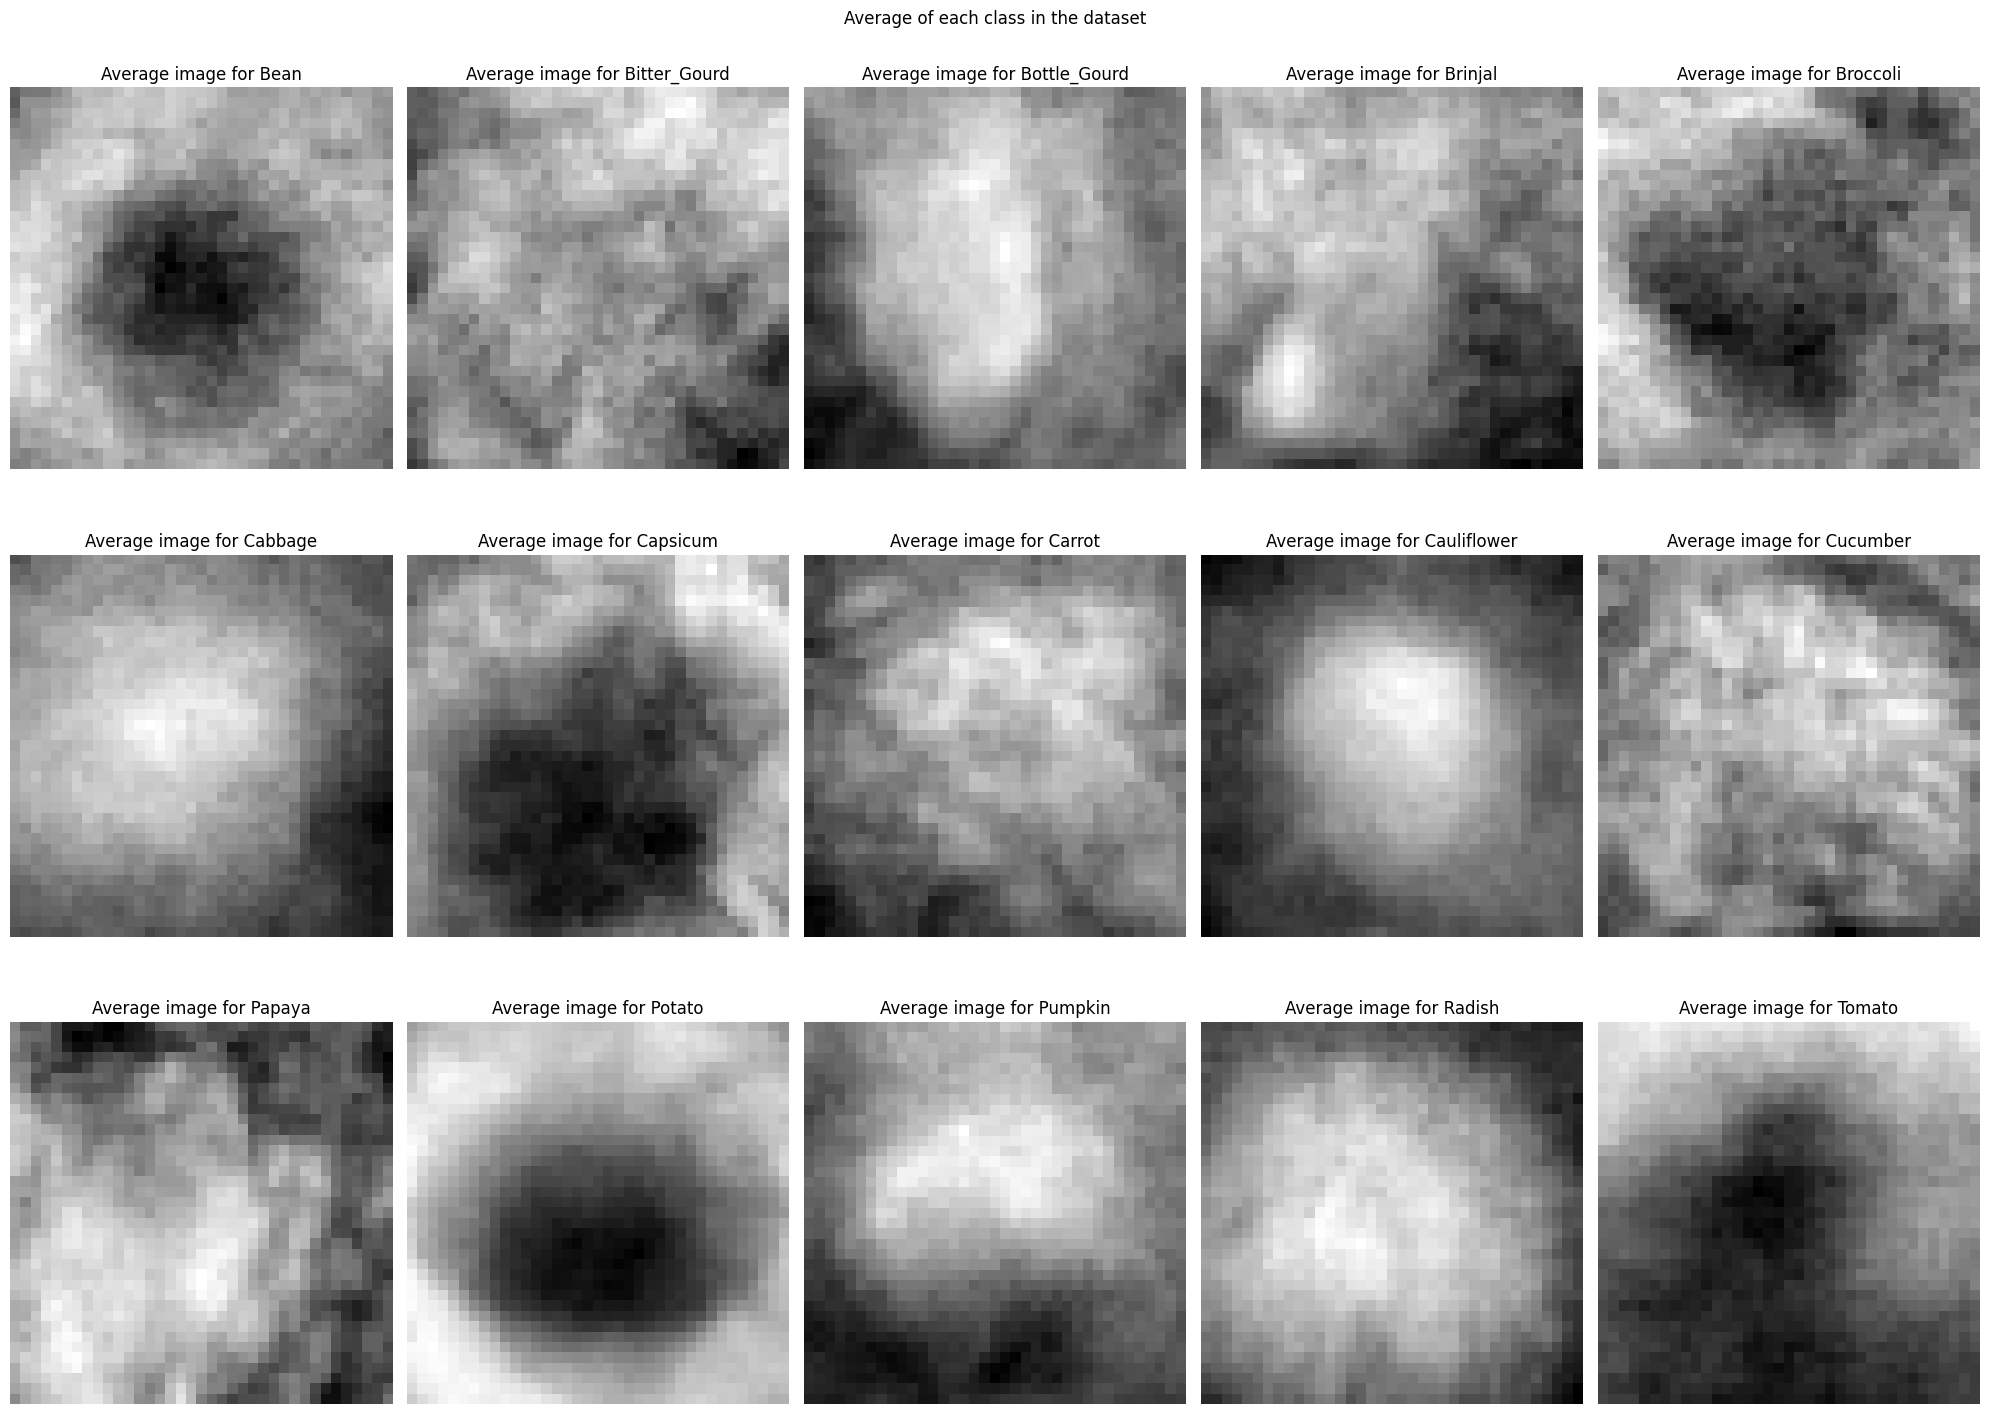

In [33]:
cnnf.average_images_per_class(train_dataset_37,class_names)

From the average pixel values in the images by classes, we can see there are some differences in the vegetables. For vegetables **Bean**, **Capsicum**, **Broccoli**, **Potato** and **Tomato**, there tends to be a darker spot in the center of the images. While for vegetables **Bottle_Gourd**, **Cabbage**, **Cauliflower**, **Papaya**, **Pumpkin** and **Radish**, there tends to be a lighter spot in the center of the images. 

The model might to use these differences as features for its identification. However, we should do more work to the data, to extract as much information as we can given what we have.

# Feature Engineering or Data Augmentation

Firstly, to ensure that what we are doing is positively affecting the accuracy of the model, we need a baseline model to test with.

### Baseline Model

For our baseline models, we should use a simple CNN model, making use of Tensorflow Cov2D layers.

The Cov2D layers are more optimal layers to use than others like Dense as Cov2D uses less parameters, perverse spatial information of the image, and is able to detects features like edges and patterns. This will allow our model to understand the image as a whole rather than as individual pixel values. 

For the loss function, we should use Sparse Categorical Crossentropy. This loss function is better suited for our nature of dataset, which has a large amount of classes. Sparse Categorical Crossentropy is great as it does not require one-hot encoding. Thus, it is more memory efficient than other loss functions like Categorical Crossentropy. This also mean we can skip the one-hot encoding step.

Lastly, for our optimizer, we should we Adam. Adam is generally a recommended optimizer due to its effectiveness and adaptability. Adam has adaptive learning rate, meaning it can adapt the learning rate based on each of the weights in the model. It also combines 2 popular optimizer, RMSProp and Momentum, thus it can deal with non-staionary objectives and sparse gradients, and be able to accelerate the convergence in the relevant direction.

In [34]:
num_classes = len(class_names)

# The baseline_model followss the model from this guide
# https://www.tensorflow.org/tutorials/images/classification#create_the_model

baseline_model = Sequential()
baseline_model.add(Conv2D(16, (3,3), padding="same", activation="relu"))
baseline_model.add(MaxPooling2D())
baseline_model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
baseline_model.add(MaxPooling2D())
baseline_model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
baseline_model.add(MaxPooling2D())
baseline_model.add(Flatten())
baseline_model.add(Dense(128, activation="relu"))
baseline_model.add(Dense(num_classes))
baseline_model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

baseline131_model = 

SyntaxError: invalid syntax (4047459030.py, line 18)